Minimum text conditional audio generation latent diffusion DDPM training / generation code for personal understaning.  

- data : ESC50 audio datasets     
- model : timestep and text conditional transformer  
- text encoder : pretrained multimodal encoder `sentence-transformers/all-MiniLM-L6-v2` (freezed)  
- latent encoder : pretrained encodec model (freezed)     
- timestep conditionong : applys shift and scale modulate by timesteps to iamge and conditioning image stacked image & adding to image at each Transformer blocks  
- text conditioning : fuse image latents with text embedding using cross attention at each Unet layers  

FAILED


In [ ]:
!pip install -q -U datasets einops transformers diffusers autoawq

In [2]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip

--2025-02-08 05:35:09--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2025-02-08 05:35:09--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-02-08 05:35:10--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <

In [3]:
!unzip -q master.zip

In [46]:
from typing import Tuple, Any, List, Dict, Optional, Union
import math
import os
import IPython

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
import datasets
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModel, CLIPTextModel, DistilBertModel, EncodecModel, AutoProcessor
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image

import warnings
warnings.simplefilter('ignore')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [6]:
# Data Config
USE_CLIP_TEXT_ENCODER = False
TEXT_PADDING_MAX_LENGTH = 150 if not USE_CLIP_TEXT_ENCODER else 77  # clip support only max token length of 77
TEXT_EMB_DIM = 384

# Training Config
EPOCHS = 100
TRAIN_BATCH_SIZE = 32
LR = 1e-4
WEIGHT_DECAY = 1e-2

# Model Config
TIME_EMBEDDING_HIDDEN_SIZE = 1024
TIME_EMBEDDING_FREQ_EMB_SIZE = 1024

# Diffusion Config
STEPS = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32#torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
use_amp = False
amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

In [7]:
device, dtype, amp_dtype

(device(type='cuda'), torch.float32, torch.bfloat16)

## 1.1. Load Pretrained Text Encoder

In [8]:
# text_encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').eval()
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
text_encoder = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device).eval()

# tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
# text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=torch.bfloat16, attn_implementation="sdpa").to(device).eval()

# tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/clip-ViT-B-32-multilingual-v1")
# text_encoder = DistilBertModel.from_pretrained("sentence-transformers/clip-ViT-B-32-multilingual-v1", torch_dtype=torch.float32).to(device).eval()

# tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ")
# text_encoder = AutoModel.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ", torch_dtype=torch.bfloat16).to(device).eval()

_ = text_encoder.requires_grad_(False)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [9]:
TEXT_EMB_DIM = text_encoder.config.hidden_size

## 1.2. Load Pretrained Audio Encoder

In [10]:
audio_encoder = EncodecModel.from_pretrained("facebook/encodec_24khz").eval().to('cuda')
audio_processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")
_ = audio_encoder.requires_grad_(False)

config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/93.1M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

In [50]:
SAMPLING_RATE = audio_processor.sampling_rate
AUDIO_EMB_DIM = audio_encoder.config.hidden_size
ADUIO_EMB_SCALE_FACTOR = 0.1

print(SAMPLING_RATE, AUDIO_EMB_DIM)

24000 128


In [12]:
@torch.inference_mode()
def _encodec_waveform2emb_frame(
    encodec_model, input_values: torch.Tensor, bandwidth: float, padding_mask: int
):
    """
    Encodes the given input using the underlying VQVAE. If `config.normalize` is set to `True` the input is first
    normalized. The padding mask is required to compute the correct scale.
    """
    length = input_values.shape[-1]
    duration = length / encodec_model.config.sampling_rate

    if encodec_model.config.chunk_length_s is not None and duration > 1e-5 + encodec_model.config.chunk_length_s:
        raise RuntimeError(f"Duration of frame ({duration}) is longer than chunk {self.config.chunk_length_s}")

    scale = None
    if encodec_model.config.normalize:
        # if the padding is non zero
        input_values = input_values * padding_mask.unsqueeze(1)
        mono = torch.sum(input_values, 1, keepdim=True) / input_values.shape[1]
        scale = mono.pow(2).mean(dim=-1, keepdim=True).sqrt() + 1e-8
        input_values = input_values / scale

    embeddings = encodec_model.encoder(input_values)
    codes = encodec_model.quantizer.encode(embeddings, bandwidth)
    codes = codes.transpose(0, 1)
    return codes, scale, embeddings

@torch.inference_mode()
def encodec_waveform2emb(
    encodec_model,
    input_values: torch.Tensor,
    padding_mask: torch.Tensor = None,
    bandwidth: Optional[float] = None,
    return_dict: Optional[bool] = None,
):
    """
    Encodes the input audio waveform into discrete codes.

    Args:
        input_values (`torch.Tensor` of shape `(batch_size, channels, sequence_length)`):
            Float values of the input audio waveform.
        padding_mask (`torch.Tensor` of shape `(batch_size, channels, sequence_length)`):
            Padding mask used to pad the `input_values`.
        bandwidth (`float`, *optional*):
            The target bandwidth. Must be one of `config.target_bandwidths`. If `None`, uses the smallest possible
            bandwidth. bandwidth is represented as a thousandth of what it is, e.g. 6kbps bandwidth is represented
            as bandwidth == 6.0

    Returns:
        A list of frames containing the discrete encoded codes for the input audio waveform, along with rescaling
        factors for each chunk when `normalize` is True. Each frames is a tuple `(codebook, scale)`, with
        `codebook` of shape `[batch_size, num_codebooks, frames]`.
    """
    if bandwidth is None:
        bandwidth = encodec_model.config.target_bandwidths[0]
    if bandwidth not in encodec_model.config.target_bandwidths:
        raise ValueError(
            f"This model doesn't support the bandwidth {bandwidth}. "
            f"Select one of {self.config.target_bandwidths}."
        )

    _, channels, input_length = input_values.shape

    if channels < 1 or channels > 2:
        raise ValueError(f"Number of audio channels must be 1 or 2, but got {channels}")

    chunk_length = encodec_model.config.chunk_length
    if chunk_length is None:
        chunk_length = input_length
        stride = input_length
    else:
        stride = encodec_model.config.chunk_stride

    if padding_mask is None:
        padding_mask = torch.ones_like(input_values).bool()

    encoded_frames = []
    scales = []
    embedding_frames = []

    step = chunk_length - stride
    if (input_length % stride) - step != 0:
        raise ValueError(
            "The input length is not properly padded for batched chunked decoding. Make sure to pad the input correctly."
        )

    for offset in range(0, input_length - step, stride):
        mask = padding_mask[..., offset : offset + chunk_length].bool()
        frame = input_values[:, :, offset : offset + chunk_length]
        encoded_frame, scale, embeddings = _encodec_waveform2emb_frame(encodec_model, frame, bandwidth, mask)
        encoded_frames.append(encoded_frame)
        scales.append(scale)
        embedding_frames.append(embeddings)

    encoded_frames = torch.stack(encoded_frames)  # (n_chunks, batch_size, n_codebooks, seq_len(n_frames))
    embedding_frames = torch.stack(embedding_frames)  # (n_chunks, batch_size, emb_dim, seq_len(n_frames))

    return encoded_frames, scales, embedding_frames

@torch.inference_mode()
def encodec_emb2code(encodec_model, embedding_frames):
    bandwidth = encodec_model.config.target_bandwidths[0]
    n_frames = embedding_frames.shape[0]
    codes = torch.stack([encodec_model.quantizer.encode(embedding_frames[i], bandwidth).transpose(0, 1) for i in range(n_frames)])
    return codes

@torch.inference_mode()
def reconstruct_audio_from_emb(encodec_model, embedding_frames, scales=[None]):
    code = encodec_emb2code(encodec_model, embedding_frames)
    # reconst_audio = audio_encoder.decode(code_from_emb, scales, inputs["padding_mask"])[0]
    reconst_audio = audio_encoder.decode(code, scales)[0]
    return reconst_audio

## 2. Data Pereparation

In [13]:
AUDIO_BASE_DIR = '/content/ESC-50-master'
df_audio_meta = pd.read_csv(f'{AUDIO_BASE_DIR}/meta/esc50.csv')
df_audio_meta['filepath'] = df_audio_meta['audio'] = AUDIO_BASE_DIR + '/audio/' + df_audio_meta['filename']
df_audio_meta['text'] = df_audio_meta['category'].map(lambda x: x.replace('_', ' '))

In [14]:
df_audio_meta

filename  fold  target        category  esc10  src_file take  \
0      1-100032-A-0.wav     1       0             dog   True    100032    A   
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A   
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A   
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B   
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A   
...                 ...   ...     ...             ...    ...       ...  ...   
1995   5-263831-B-6.wav     5       6             hen  False    263831    B   
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A   
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A   
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A   
1999     5-9032-A-0.wav     5       0             dog   True      9032    A   

                                            filepath  \
0      /content/ESC-50-master/audio/1-100032-A-0.wav   
1     /content/ESC-50-master/audio/1-100038-A-14.wav   
2     /content/ESC-50-master/audio/1-100210-A-36.wav   
3     /content/ESC-50-master/audio/1-100210-B-36.wav   
4     /content/ESC-50-master/audio/1-101296-A-19.wav   
...                                              ...   
1995   /content/ESC-50-master/audio/5-263831-B-6.wav   
1996  /content/ESC-50-master/audio/5-263902-A-36.wav   
1997   /content/ESC-50-master/audio/5-51149-A-25.wav   
1998    /content/ESC-50-master/audio/5-61635-A-8.wav   
1999     /content/ESC-50-master/audio/5-9032-A-0.wav   

                                               audio            text  
0      /content/ESC-50-master/audio/1-100032-A-0.wav             dog  
1     /content/ESC-50-master/audio/1-100038-A-14.wav  chirping birds  
2     /content/ESC-50-master/audio/1-100210-A-36.wav  vacuum cleaner  
3     /content/ESC-50-master/audio/1-100210-B-36.wav  vacuum cleaner  
4     /content/ESC-50-master/audio/1-101296-A-19.wav    thunderstorm  
...                                              ...             ...  
1995   /content/ESC-50-master/audio/5-263831-B-6.wav             hen  
1996  /content/ESC-50-master/audio/5-263902-A-36.wav  vacuum cleaner  
1997   /content/ESC-50-master/audio/5-51149-A-25.wav       footsteps  
1998    /content/ESC-50-master/audio/5-61635-A-8.wav           sheep  
1999     /content/ESC-50-master/audio/5-9032-A-0.wav             dog  

[2000 rows x 10 columns]

In [15]:
hf_dataset = datasets.Dataset.from_pandas(df_audio_meta)

In [16]:
hf_dataset = hf_dataset.cast_column("audio", datasets.Audio(sampling_rate=SAMPLING_RATE))

In [17]:
hf_dataset

Dataset({
    features: ['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take', 'filepath', 'audio', 'text'],
    num_rows: 2000
})

In [18]:
hf_dataset[1]

{'filename': '1-100038-A-14.wav',
 'fold': 1,
 'target': 14,
 'category': 'chirping_birds',
 'esc10': False,
 'src_file': 100038,
 'take': 'A',
 'filepath': '/content/ESC-50-master/audio/1-100038-A-14.wav',
 'audio': {'path': '/content/ESC-50-master/audio/1-100038-A-14.wav',
  'array': array([-0.02733315, -0.13533971, -0.09666637, ...,  0.07749223,
          0.03224546,  0.        ]),
  'sampling_rate': 24000},
 'text': 'chirping birds'}

In [19]:
IPython.display.Audio(hf_dataset[1]['audio']['array'], rate=hf_dataset[1]['audio']['sampling_rate'])

In [20]:
sr_token_counts = pd.Series(hf_dataset['text']).map(lambda x: len(tokenizer(x, return_tensors='pt')['input_ids'][0]))

<Axes: ylabel='Frequency'>

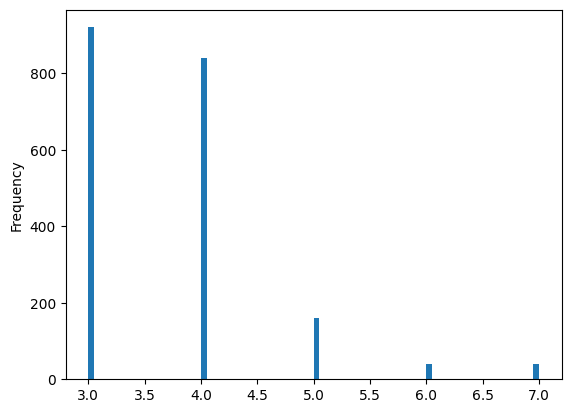

In [21]:
sr_token_counts.plot.hist(bins=80)

In [22]:
hf_dataset[1]['audio']['array'].shape

(120001,)

In [23]:
def from_seq_to_encodec_format(emb, chunk=1):
    return einops.rearrange(emb, 'bs (n_chunks seq_len) emb_dim -> n_chunks bs emb_dim seq_len', n_chunks=1)

@torch.inference_mode()
def encode_text(texts):
    inputs = tokenizer(texts, padding='max_length', max_length=TEXT_PADDING_MAX_LENGTH, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    text_encoder_output = text_encoder(**inputs)
    text_emb = text_encoder_output['last_hidden_state']
    return inputs['attention_mask'].bool(), text_emb

@torch.inference_mode()
def encode_audio(audio_dict_list, audio_encoder=audio_encoder):
    raw_audio_list = [d['array'] for d in audio_dict_list]
    inputs = audio_processor(
        raw_audio=raw_audio_list, sampling_rate=audio_processor.sampling_rate, return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    codes, scales, embs = encodec_waveform2emb(
        audio_encoder,
        input_values=inputs["input_values"],
        padding_mask=inputs["padding_mask"],
    )
    # print(embs.shape, len(raw_audio_list))
    embs = einops.rearrange(embs, 'n_chunks bs emb_dim seq_len -> bs (n_chunks seq_len) emb_dim') # (n_chunks, bs, emb_dim, seq_len) => (bs, n_chunks, seq_len, emb_dim)
    return embs, inputs["padding_mask"]

def preprocess_data(examples):
    audio_emb, audio_padding_mask = encode_audio(examples['audio'])
    examples["audio_emb"] = audio_emb
    # examples["audio_padding_mask"] = audio_padding_mask

    text_attn_mask, text_emb = encode_text(examples['text'])
    examples["text_emb"] = text_emb
    examples["text_attn_mask"] = text_attn_mask

    return examples

In [24]:
%%time
hf_dataset = hf_dataset.with_transform(preprocess_data)

Parameter 'transform'=<function preprocess_data at 0x7edf0487c4a0> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


CPU times: user 34.5 ms, sys: 1.76 ms, total: 36.2 ms
Wall time: 39.8 ms


In [25]:
hf_dataset[0].keys()

dict_keys(['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take', 'filepath', 'audio', 'text', 'audio_emb', 'text_emb', 'text_attn_mask'])

In [26]:
hf_dataset[0]['audio_emb'].shape#, hf_dataset[0]['audio_padding_mask'].shape

torch.Size([376, 128])

In [27]:
AUDIO_EMB_SEQ_LEN = hf_dataset[0]['audio_emb'].shape[0]

In [28]:
hf_dataset = hf_dataset.remove_columns([
    'filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take'
])

In [29]:
hf_dataset[0].keys()

dict_keys(['filepath', 'audio', 'text', 'audio_emb', 'text_emb', 'text_attn_mask'])

In [30]:
def collate_fn(examples):
    audio_emb = torch.stack([example["audio_emb"] for example in examples])
    # audio_padding_mask = torch.stack([example["audio_padding_mask"] for example in examples])

    text_emb = torch.stack([example["text_emb"] for example in examples])
    text_attn_mask = torch.stack([example["text_attn_mask"] for example in examples])

    return {
        "audio_emb": audio_emb.to(dtype),
        # 'audio_padding_mask': audio_padding_mask,
        "text_emb": text_emb.to(dtype),
        'text_attn_mask': text_attn_mask,
    }

In [31]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)

In [ ]:
_batch = next(iter(train_dataloader))

In [ ]:
{k: v.shape for k, v in _batch.items()}

{'audio_emb': torch.Size([32, 376, 128]),
 'text_emb': torch.Size([32, 150, 384]),
 'text_attn_mask': torch.Size([32, 150])}

In [ ]:
reconstructed_audio = reconstruct_audio_from_emb(audio_encoder, from_seq_to_encodec_format(_batch['audio_emb']))

In [ ]:
reconstructed_audio.shape

torch.Size([32, 1, 120320])

In [ ]:
IPython.display.Audio(reconstructed_audio[2].cpu().numpy(), rate=SAMPLING_RATE)

## 3. Model

In [32]:
# Time Embedder (borrowed from micro diffusion)

class TimestepEmbedder(nn.Module):
    """Embeds scalar timesteps into vector representations.

    Args:
        hidden_size (int): Size of hidden dimension
        act_layer (Any): Activation layer constructor
        frequency_embedding_size (int, 512): Size of frequency embedding
    """
    def __init__(
        self,
        hidden_size: int,
        act_layer: Any = nn.SiLU,
        frequency_embedding_size: int = TIME_EMBEDDING_FREQ_EMB_SIZE
    ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            act_layer(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t: torch.Tensor, dim: int, max_period: int = 10000) -> torch.Tensor:
        """Create sinusoidal timestep embeddings."""
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(
                start=0,
                end=half,
                dtype=torch.float32,
                device=t.device
            ) / half
        )
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size).to(self.dtype)
        return self.mlp(t_freq)

    @property
    def dtype(self) -> torch.dtype:
        return next(self.parameters()).dtype

In [33]:
# TimestepEmbedder(hidden_size=28*28).eval()(torch.arange(0, 1000)).detach().shape

In [71]:
def modulate(x: torch.Tensor, shift: torch.Tensor, scale: torch.Tensor) -> torch.Tensor:
    """Applies modulation to input tensor using shift and scale factors."""
    return x * (1 + scale) + shift

def positionalencoding1d(d_model, length, dtype=dtype):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe.to(dtype)

class CrossAttn(nn.Module):
    def __init__(
        self,
        x_dim: int,
        c_dim: int,
        hidden_size: int = None,
        dropout: float = 0.05,
        num_heads: int = 8,
    ):
        super().__init__()
        if hidden_size is None:
            hidden_size = x_dim

        self.x_in_proj = nn.Linear(x_dim, hidden_size)
        self.x_out_proj = nn.Linear(hidden_size, x_dim) if x_dim != hidden_size else nn.Identity()
        self.c_in_proj = nn.Linear(c_dim, hidden_size)
        # self.attn = nn.MultiheadAttention(hidden_size, num_heads, dropout=0.0, bias=True, batch_first=True)
        self.act = nn.GELU()
        self.dropout = dropout
        self.norm = nn.LayerNorm(hidden_size)
        self.num_heads = num_heads

    def forward(self, x, c, c_mask = None, x_pos_emb = None):
        """
        x: (bs, x_seq_len, x_dim)
        c: (bs, c_seq_len, c_dim)
        c_mask: (bs, c_seq_len)
        x_patch_pos_emb: (bs, x_max_seq_len, emb_dim)
        """
        x_proj = self.act(self.norm(self.x_in_proj(x)))  # (bs, x_seq_len, x_dim) => (bs, x_seq_len, hidden_size)
        c_proj = self.act(self.norm(self.c_in_proj(c)))  # (bs, c_seq_len, c_dim) => (bs, c_seq_len, hidden_size)
        if x_pos_emb is not None:
            x_proj = x_proj + x_pos_emb[:, :x_proj.shape[1], :x_proj.shape[2]].to(x.device)
        if c_mask is not None:
            c_mask = c_mask.unsqueeze(1).unsqueeze(1)  # (bs, seq_len_c) => (bs, 1(for heads), 1(for seq_len_x), seq_len_c)
        hidden_size = x_proj.shape[-1]
        x_proj = einops.rearrange(x_proj, 'b sl (nh d) -> b nh sl d', nh=self.num_heads, d=hidden_size // self.num_heads)  # (bs, num_heads, x_seq_len, hidden_size_head)
        c_proj = einops.rearrange(c_proj, 'b sl (nh d) -> b nh sl d', nh=self.num_heads, d=hidden_size // self.num_heads)  # (bs, num_heads, c_seq_len, hidden_size_head)
        x_c_fused = F.scaled_dot_product_attention(query=x_proj, key=c_proj, value=c_proj, attn_mask=c_mask, dropout_p=self.dropout, is_causal=False)  # (bs, x_seq_len, hidden_size)
        x_c_fused = einops.rearrange(x_c_fused, 'b nh sl d -> b sl (nh d)', nh=self.num_heads, d=hidden_size // self.num_heads)  # (bs, x_seq_len, hidden_size)

        x_c_fused = self.act(self.norm(x_c_fused))  # (bs, x_seq_len, hidden_size)
        x_c_fused = self.x_out_proj(x_c_fused)  # (bs, x_seq_len, hidden_size) => (bs, x_seq_len, x_dim)
        assert x.shape == x_c_fused.shape
        return x + x_c_fused

class TransformerBlock(nn.Module):
    def __init__(
        self,
        x_dim: int,
        c_dim: int,
        hidden_size: int = None,
        dropout: float = 0.05,
        num_heads: int = 8,
        t_emb_dim: int = None,
    ):
        super().__init__()
        if hidden_size is None:
            hidden_size = x_dim
        self.x_in_proj = nn.Linear(x_dim, hidden_size)# if x_dim != hidden_size else None
        self.x_out_proj = nn.Linear(hidden_size, x_dim) if x_dim != hidden_size else nn.Identity()
        self.time_emb_proj = nn.Linear(t_emb_dim, hidden_size) if t_emb_dim is not None else None
        self.x_time_encoder = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout, activation=nn.GELU(), batch_first=True)
        self.x_c_fuser = CrossAttn(
            x_dim=hidden_size,
            c_dim=c_dim,
            hidden_size=hidden_size,
            dropout=dropout,
            num_heads=num_heads,
        )
        self.act = nn.GELU()
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = dropout

    def forward(self, x, c, c_mask = None, x_pos_emb = None, t_emb=None):
        """
        x: (bs, x_seq_len, x_dim)
        c: (bs, c_seq_len, c_dim)
        c_mask: (bs, c_seq_len)
        x_patch_pos_emb: (bs, x_max_seq_len, emb_dim)
        t_emb: (bs, t_emb_dim)
        """
        x_residual = x
        if self.x_in_proj is not None:
            x = self.act(self.norm(self.x_in_proj(x)))  # (bs, x_seq_len, x_dim) => (bs, x_seq_len, hidden_size)
        if t_emb is not None:
            x = x + self.act(self.norm(self.time_emb_proj(t_emb))).unsqueeze(1)
        x = self.x_time_encoder(x)
        x_c_fused = self.x_c_fuser(x=x, c=c, c_mask=c_mask, x_pos_emb=x_pos_emb)  # (bs, x_seq_len, hidden_size)
        x_c_fused = self.x_out_proj(x_c_fused)  # (bs, x_seq_len, hidden_size) => (bs, x_seq_len, x_dim)
        assert x.shape == x_c_fused.shape
        return x_residual + x_c_fused

In [72]:
class ConditionalTransformer(nn.Module):
    def __init__(
        self,
        hidden_size: int = 1024,
        audio_emb_shape: Tuple[int, int] = (AUDIO_EMB_SEQ_LEN, AUDIO_EMB_DIM),
        c_emb_dim = TEXT_EMB_DIM,
        t_emb_dim: int = TIME_EMBEDDING_HIDDEN_SIZE,
        dropout = 0.05,
        n_layers: int = 8,
        num_heads: int = 8,
    ):
        super(ConditionalTransformer, self).__init__()

        self.t_emb_dim = t_emb_dim
        self.audio_emb_shape = audio_emb_shape

        self.x_in_proj = nn.Linear(audio_emb_shape[-1], hidden_size)
        self.transformer_blocks = nn.Sequential(*[
            TransformerBlock(
                x_dim=hidden_size,
                c_dim=c_emb_dim,
                hidden_size=hidden_size,
                dropout=dropout,
                num_heads=num_heads,
                t_emb_dim=t_emb_dim,
            )
            for i in range(n_layers)
        ])
        self.x_out_proj = nn.Linear(hidden_size, audio_emb_shape[-1])
        self.act = nn.GELU()
        self.norm = nn.LayerNorm(hidden_size)
        self._x_pos_emb = positionalencoding1d(hidden_size, audio_emb_shape[0]).unsqueeze(0)  # (1, max_seq_len, max_dim)

    def forward(self, x, c, c_mask = None, t_emb = None):
        """
        x: (bs, x_seq_len, x_dim)
        c: (bs, c_seq_len, c_dim)
        c_mask: (bs, c_seq_len)
        t_emb: timestep embeddings of shape (bs, emb_dim)
        """
        x_residual = x
        x = self.act(self.norm(self.x_in_proj(x)))  # (bs, x_seq_len, x_dim) => (bs, x_seq_len, hidden_size)
        for m in self.transformer_blocks:
            x = m(x=x, c=c, c_mask=c_mask, x_pos_emb=self._x_pos_emb, t_emb=t_emb)
        x = self.x_out_proj(x)  # (bs, x_seq_len, hidden_size) => (bs, x_seq_len, x_dim)
        return x_residual + x


In [73]:
class DenoiseModel(torch.nn.Module):
    def __init__(
        self,
        audio_emb_shape: Tuple[int, int] = (AUDIO_EMB_SEQ_LEN, AUDIO_EMB_DIM),
        time_emb_dim: int = TIME_EMBEDDING_HIDDEN_SIZE,
        hidden_size: int = 1024,
        n_layers: int = 8,
    ):
        super().__init__()
        self._audio_emb_shape = audio_emb_shape
        self._transformer_denoiser = ConditionalTransformer(hidden_size=hidden_size, n_layers=n_layers)
        self._timestep_embedder = TimestepEmbedder(hidden_size=time_emb_dim)
        self._adaLN_modulation = nn.Sequential(
            nn.GELU(approximate="tanh"),
            nn.Linear(time_emb_dim, 2 * audio_emb_shape[0], bias=True),
        )
        self._c_pos_emb = positionalencoding1d(TEXT_EMB_DIM, TEXT_PADDING_MAX_LENGTH).unsqueeze(0)  # (1, max_seq_len, max_dim)

    def forward(self, x: torch.Tensor, t: torch.Tensor, c, c_mask = None):
        """Given noisy input image x_t and time t, predict the added noise (x_t - x_t-1).

        Args:
            x (torch.Tensor): input noisy image x_t with shape (bs, seq_len_x, emb_dim_x)
            t (torch.Tensor): time steps with shape (bs,)
            c (torch.Tensor): conditional embeddings with shape (bs, seq_len_c, emb_dim_x)
            c_mask (torch.Tensor): attention mask for c with shape (bs, seq_len_c)

        Returns:
            torch.Tensor: Predicted added noise image (x_t - x_t-1) with shape (bs, ch, h, w)
        """
        t_emb = self._timestep_embedder(t)  # (bs,) => (bs, time_emb_dim)
        shift, scale = self._adaLN_modulation(t_emb).chunk(2, dim=1)
        # shift = shift.reshape(*x.shape)  # (bs, seq_len_x x emb_dim_x) => (bs, seq_len_x, emb_dim_x)
        # scale = scale.reshape(*x.shape)  # (bs, seq_len_x x emb_dim_x) => (bs, seq_len_x, emb_dim_x)
        shift = shift.unsqueeze(-1)  # (bs, seq_len_x) => (bs, seq_len_x, 1)
        scale = scale.unsqueeze(-1)  # (bs, seq_len_x) => (bs, seq_len_x, 1)
        x_t_fused = modulate(x, shift, scale)  # make x conditioned on timesteps
        c = c + self._c_pos_emb.to(c.device)
        added_noise = x - self._transformer_denoiser(x_t_fused, c=c, c_mask=c_mask, t_emb=t_emb)
        return added_noise

In [ ]:
_denoise_model = DenoiseModel().to(device).to(dtype).eval()
torch.save(_denoise_model.state_dict(), 'denoise_model.pth')
!ls -lh ./denoise_model.pth
!rm ./denoise_model.pth

-rw-r--r-- 1 root root 345M Feb  8 13:32 ./denoise_model.pth


In [37]:
# {name: param.numel() for name, param in _denoise_model.named_parameters() if param.requires_grad}

In [ ]:
with torch.inference_mode():
    _out = _denoise_model(
        x=torch.randn(1, AUDIO_EMB_SEQ_LEN, AUDIO_EMB_DIM).to(device).to(dtype),
        t=torch.tensor([0.0]).to(device).to(dtype),
        c=torch.randn(1, TEXT_PADDING_MAX_LENGTH, TEXT_EMB_DIM).to(device).to(dtype),
        c_mask=torch.ones(1, TEXT_PADDING_MAX_LENGTH).to(device),
    )
    print(_out.shape)

torch.Size([1, 376, 128])


## 4. DDPM Scheduler Utils

In [38]:
def get_alpha_beta_sigma_scheduler(
    steps: int,
    # noise_beta = (0.5, 1.0),
    noise_beta = (0.0001, 0.02),
    device = device,
    dtype = dtype,
) -> Tuple[torch.Tensor, torch.Tensor]:
    b1, b2 = noise_beta
    beta_scheduler = [b1 + i*(b2-b1)/steps for i in range(steps)]
    alpha_scheduler = [1.0 - beta for beta in beta_scheduler]
    beta_scheduler = torch.tensor(beta_scheduler, device=device, dtype=torch.float32)
    alpha_scheduler = torch.tensor(alpha_scheduler, device=device, dtype=torch.float32)
    alpha_cumprod_scheduler = alpha_scheduler.cumprod(0)
    sigma_scheduler = (beta_scheduler * (1.0 - alpha_cumprod_scheduler.roll(1)) / (1.0 - alpha_cumprod_scheduler)).sqrt()
    sigma_scheduler[0] = 0.0
    return beta_scheduler.to(device), alpha_scheduler.to(device), alpha_cumprod_scheduler.to(device), sigma_scheduler.to(device)

In [39]:
beta_scheduler, alpha_scheduler, alpha_cumprod_scheduler, sigma_scheduler = get_alpha_beta_sigma_scheduler(steps=STEPS, noise_beta=(0.0001, 0.02))

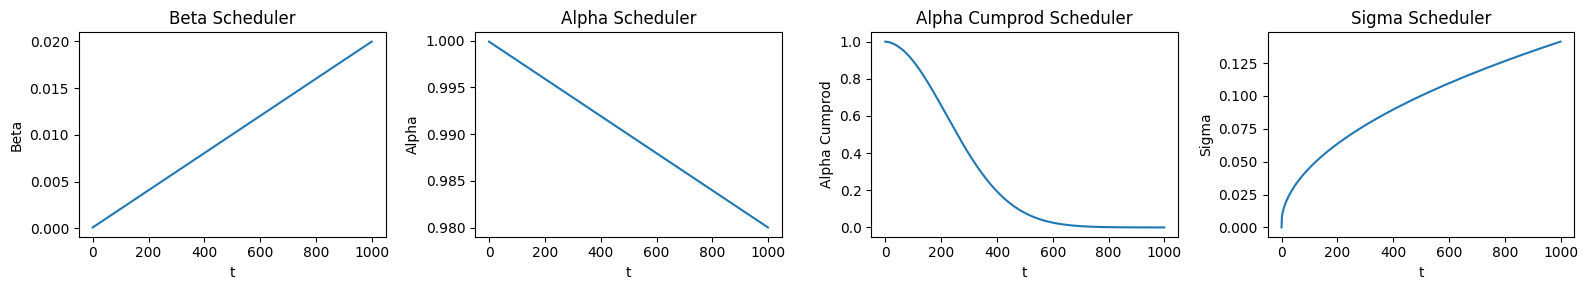

In [40]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(4*4, 3))

axes[0].plot(beta_scheduler.cpu().float().numpy())
axes[0].set_xlabel('t')
axes[0].set_ylabel('Beta')
axes[0].set_title('Beta Scheduler')

axes[1].plot(alpha_scheduler.cpu().float().numpy())
axes[1].set_xlabel('t')
axes[1].set_ylabel('Alpha')
axes[1].set_title('Alpha Scheduler')

axes[2].plot(alpha_cumprod_scheduler.cpu().float().numpy())
axes[2].set_xlabel('t')
axes[2].set_ylabel('Alpha Cumprod')
axes[2].set_title('Alpha Cumprod Scheduler')

axes[3].plot(sigma_scheduler.cpu().float().numpy())
axes[3].set_xlabel('t')
axes[3].set_ylabel('Sigma')
axes[3].set_title('Sigma Scheduler')

fig.tight_layout()

## 5. Denoise(generation) / Add Noise Utils

- Denoise (For Generation)

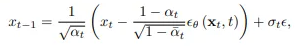

Following above equations, apply denoising process step by step to generate final image $x_0$ starting from pure noise $x_{t_{max}} \sim \mathcal{N}(0,\,1)$, where  
$\alpha_t=1-\beta_t$  
$\overline{\alpha}_{t} = \prod \alpha_t = \prod (1-\beta_t)$  
$ \sigma_{t}^2 = \frac{1.0 - \overline{\alpha}_{t-1}}{1.0 - \overline{\alpha}_{t}}\beta_t$  
$\epsilon_{\theta}(\boldsymbol{x}_{t}, t)$ : model output (predicted noise added to $x_t$)  
$\epsilon \sim \mathcal{N}(0,\,1)$


In [75]:
@torch.inference_mode()
def generate(
    denoise_model: nn.Module,
    texts: List[str],
    audio_emb_shape: Tuple[int, int] = (AUDIO_EMB_SEQ_LEN, AUDIO_EMB_DIM),
    steps: int = STEPS,
    beta_scheduler: torch.Tensor = beta_scheduler,
    alpha_scheduler: torch.Tensor = alpha_scheduler,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
    sigma_scheduler: torch.Tensor = sigma_scheduler,
    debug: bool = False,
    device = device,
    return_only_final_image: bool = True,
    dtype = dtype,
) -> torch.Tensor:
    denoise_model.eval()
    # create initial pure noise x_tmax
    text_attn_mask, text_emb = encode_text(texts)
    bs = len(texts)
    z_t = init_noise = torch.randn(bs, *audio_emb_shape).to(device).to(dtype)
    x_t_list = [reconstruct_audio_from_emb(audio_encoder, from_seq_to_encodec_format(z_t))] if not return_only_final_image else None
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
        for t in reversed(range(1, steps)):
            # predict noise to denoise from x_t
            pred_noise = denoise_model(
                z_t,
                torch.tensor([t]).repeat((bs,)).to(device).to(dtype),
                c=text_emb.to(device).to(dtype),
                c_mask=text_attn_mask.to(device),
            )
            # apply denoise equation above
            z_prev_t = z_t - pred_noise * (1 - alpha_scheduler[t]) / ((1 - alpha_cumprod_scheduler[t]).sqrt())
            z_prev_t /= alpha_scheduler[t].sqrt()
            z_prev_t += sigma_scheduler[t] * torch.randn_like(z_prev_t)
            z_t = z_prev_t
            if not return_only_final_image:
                x_t_list.append(reconstruct_audio_from_emb(audio_encoder, from_seq_to_encodec_format(z_t / ADUIO_EMB_SCALE_FACTOR)))

    if return_only_final_image:
        x_0 = reconstruct_audio_from_emb(audio_encoder, from_seq_to_encodec_format(z_t / ADUIO_EMB_SCALE_FACTOR))  # generated image x_0  (n_generate, 1, waveform_len)
    else:
        x_0 = torch.stack(x_t_list, dim=0)  # (steps, n_generate, 1, waveform_len)
    return x_0

In [ ]:
%%time
gen_audio = generate(_denoise_model, texts=[hf_dataset[0]['text']])
print(gen_audio.shape)

torch.Size([1, 1, 120320])


In [ ]:
IPython.display.Audio(gen_audio[0].cpu().numpy(), rate=SAMPLING_RATE)

- Add Noise (For Training)

image.png

In [42]:
def add_noise(
    x_0: torch.Tensor,
    steps: int = STEPS,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
    dtype = dtype,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Add noise corresponding to random time steps to ground-truth image x_0 to get x_t_rand

    Args:
        x (torch.Tensor): input ground-trueth image x_0 with shape (bs, ch, h, w)

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: noised added image x_t_rand, added noise, random timestepps correponsing to added noise
    """
    bs, seq_len, dim = x_0.shape
    random_timesteps = torch.randint(0, steps, (bs,)).to(x_0.device)
    alpha_prod = alpha_cumprod_scheduler[random_timesteps].reshape((bs, 1, 1))

    noise = torch.randn_like(x_0)#.to(dtype)
    x_noisy = x_0 * alpha_prod.sqrt() + noise * (1 - alpha_prod).sqrt()
    return x_noisy, noise, random_timesteps

In [ ]:
_x_noisy, _noise, _random_timesteps = add_noise(next(iter(train_dataloader))['audio_emb'].to(device).to(dtype))
print(_x_noisy.shape, _noise.shape, _random_timesteps.shape)

torch.Size([32, 376, 128]) torch.Size([32, 376, 128]) torch.Size([32])


## 6. Run Training

In [43]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [74]:
model = DenoiseModel(n_layers=10).to(device).to(dtype)
# model.load_state_dict(torch.load('./denoise_model_encodec_esc50_tmp.pt'))

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=3*len(train_dataloader),
    num_training_steps=2*EPOCHS*len(train_dataloader),
)

scaler = torch.amp.GradScaler(device='cuda', enabled=use_amp)

In [ ]:
loss_history = []

for epoch in range(EPOCHS):
    # Train phase
    model.train()
    epoch_loss = 0.0
    for batch in pb(train_dataloader):
        batch = batch_to_device(batch, device)
        optimizer.zero_grad()
        z = ADUIO_EMB_SCALE_FACTOR * batch['audio_emb'].to(dtype)
        text_emb = batch['text_emb'].to(dtype)
        text_attn_mask = batch['text_attn_mask']
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
            z_noisy, noise, random_timesteps = add_noise(z, steps=STEPS)  # (bs, ch, h, w), (bs, ch, h, w), (bs,)
            pred_noise = model(
                x=z_noisy.to(dtype),
                t=random_timesteps,
                c=text_emb,
                c_mask=text_attn_mask,
            )  # (bs, ch, h, w)
            loss = torch.nn.functional.mse_loss(pred_noise.cpu().float(), noise.cpu().float())
            if torch.isnan(loss):
                print('loss is nan')
                raise Exception()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        epoch_loss += loss.cpu().detach()
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]}')

    # Ealuluation Phase
    model.eval()
    random_selected_data = hf_dataset.shuffle().select(range(2))[:]
    texts = random_selected_data['text']
    print('\n'.join(texts))
    gt_audio = reconstruct_audio_from_emb(audio_encoder, from_seq_to_encodec_format(random_selected_data['audio_emb']))
    display(IPython.display.Audio(gt_audio[0].cpu().numpy(), rate=SAMPLING_RATE))
    display(IPython.display.Audio(gt_audio[1].cpu().numpy(), rate=SAMPLING_RATE))
    gen_audio = generate(model, texts=texts)
    print('generated audio')
    display(IPython.display.Audio(gen_audio[0].cpu().numpy(), rate=SAMPLING_RATE))
    display(IPython.display.Audio(gen_audio[1].cpu().numpy(), rate=SAMPLING_RATE))

    torch.save(model.state_dict(), f'./denoise_model_encodec_esc50_tmp.pt')
    print(scheduler.get_lr())

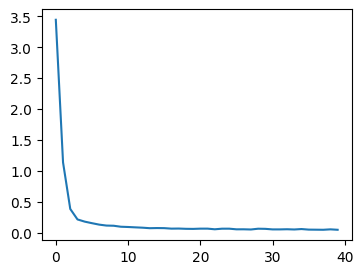

In [77]:
plt.figure(figsize=(4, 3))
plt.plot(loss_history)

## 7. Generate Audio with Trained Model

In [78]:
%%time
random_selected_data = hf_dataset.shuffle().select(range(6))[:]
texts = random_selected_data['text']
gen_audio = generate(model, texts=texts)

CPU times: user 2min 22s, sys: 325 ms, total: 2min 23s
Wall time: 3min


In [79]:
gt_audio = reconstruct_audio_from_emb(audio_encoder, from_seq_to_encodec_format(random_selected_data['audio_emb']))

water drops


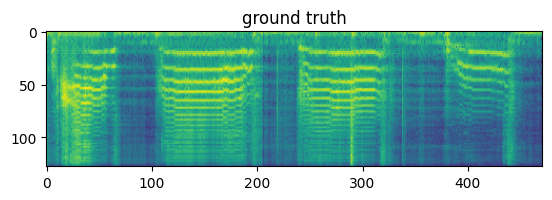

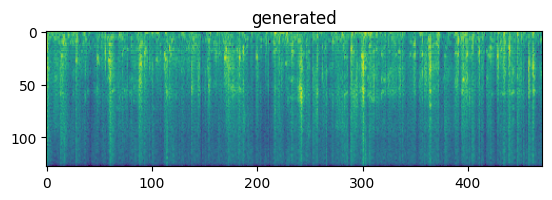

rooster


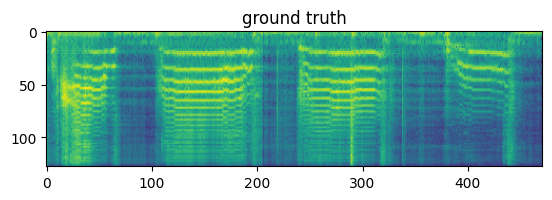

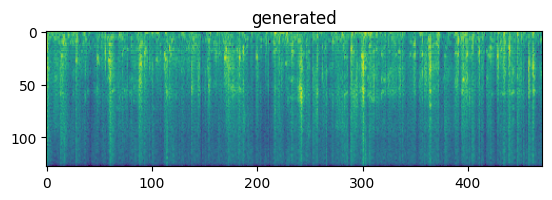

cat


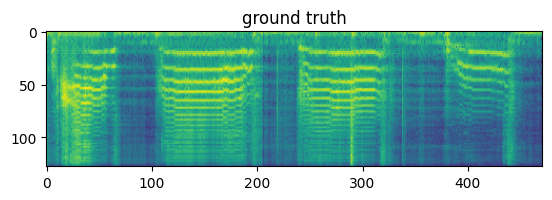

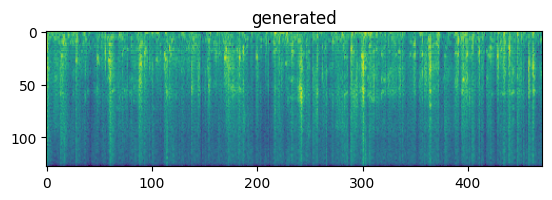

breathing


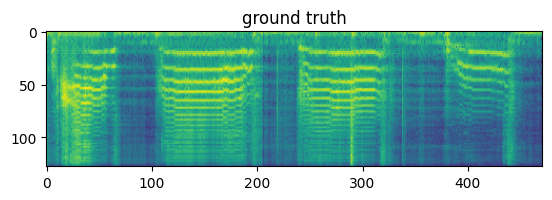

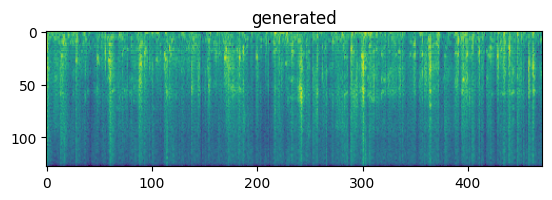

train


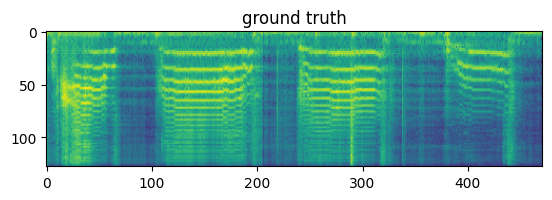

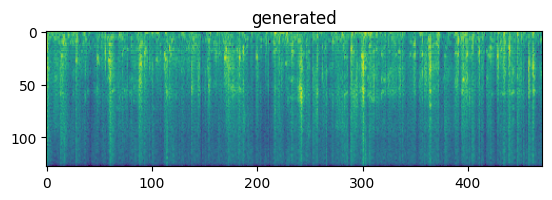

siren


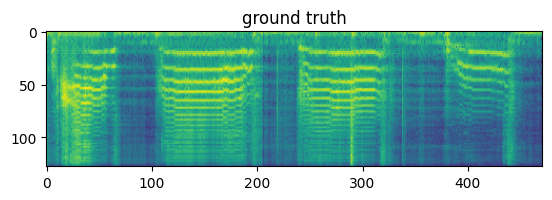

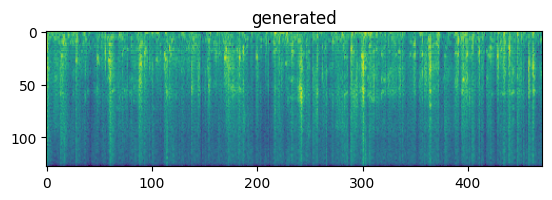

In [81]:
for i, text in enumerate(texts):
    print(text)
    display(IPython.display.Audio(gt_audio[i].cpu().numpy(), rate=SAMPLING_RATE))
    plt.imshow(torchaudio.transforms.MelSpectrogram(n_fft=512)(gt_audio[2].cpu()).log2().squeeze().numpy())
    plt.title('ground truth')
    plt.show()
    display(IPython.display.Audio(gen_audio[i].cpu().numpy(), rate=SAMPLING_RATE))
    plt.imshow(torchaudio.transforms.MelSpectrogram(n_fft=512)(gen_audio[2].cpu()).log2().squeeze().numpy())
    plt.title('generated')
    plt.show()
    print('='*200)